# 第4章　データ前処理ーよりよいトレーニングセットの構築
***

## 4.1 欠損データへの対処

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("titanic_train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#不要な特徴量の削除
drop_columns = ["Survived",
                "PassengerId", 
                "Name", 
                "Ticket", 
                "Fare", 
                "Cabin"]

df = df.drop(drop_columns, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [4]:
#各特徴量の欠損値をカウント
df.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [5]:
#欠損値を持つサンプル or 特徴量を取り除く

#行（サンプル）を除く場合、axis=0(デフォルト)
#列（特徴量）を除く場合、axis=1
df = df.dropna(axis=0,
          how='any',                 #'all'にすると、「全て欠損値の行のみ削除」
          subset=['Embarked'],       #["特徴量"]を指定し、そこに欠損値がある行のみを削除
          thresh=None,               #数値を入れると、「非欠損値がその数未満の行を削除」
          inplace=False)
df.shape

(889, 6)

In [6]:
#labelエンコーディング
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder   #複数一気にできる

le_columns = ["Sex", 
              "Embarked"]            #欠損値があるとできない
for c in le_columns:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])
df

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1,22.0,1,0,2
1,1,0,38.0,1,0,0
2,3,0,26.0,0,0,2
3,1,0,35.0,1,0,2
4,3,1,35.0,0,0,2
...,...,...,...,...,...,...
886,2,1,27.0,0,0,2
887,1,0,19.0,0,0,2
888,3,0,NaN,1,2,2
889,1,1,26.0,0,0,0


In [7]:
#欠損値の補完
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN',
              strategy='mean',          #他にも'median'：中央値や'most_frequent'：最頻値なども選べる
              axis=0)

imr = imr.fit(df)               #引数はDataFrameのままでもarrayでもOK

imr_data = imr.transform(df)    #arrayに変換されてしまう

#DataFrameに戻す
df_columns = df.columns

df_imr = pd.DataFrame(data=imr_data, columns=df_columns)
df_imr.head()

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3.0,1.0,22.0,1.0,0.0,2.0
1,1.0,0.0,38.0,1.0,0.0,0.0
2,3.0,0.0,26.0,0.0,0.0,2.0
3,1.0,0.0,35.0,1.0,0.0,2.0
4,3.0,1.0,35.0,0.0,0.0,2.0


In [8]:
#欠損値がなくなっていることの確認
df_imr.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

## 4.2 カテゴリデータの処理

## 4.3 トレーニングデータとテストデータへの分割

## 4.4 特徴量の尺度を揃える（スケーリング）

## 4.5 有益な特徴量の選択

＜過学習（ハイバリアンス）に対する一般的な方法＞  
- さらに多くのトレーニングデータを集める　←難しい場合が多い
- 正則化を通じて複雑さにペナルティを課す
- パラメータの数が少ない、より単純なモデルを選択する
- データの次元を減らす

### 正則化

In [9]:
#ワインのデータセットを読み込む
df_wine = pd.read_csv('wine.data', header=None)
columns = ["Class label", "Alchol", "Malic acid","Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
           "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]

df_wine.columns = columns

df_wine.head()

,Class label,Alchol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [10]:
#データの分割
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [11]:
#標準化しておく
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [13]:
#正則化なしのLogistic回帰を試す
from sklearn.linear_model import LogisticRegression

c=np.linspace(10**-10, 0.2, 10**2)
d_list=[]

for i in c:
    lr = LogisticRegression(penalty='l2',     #'l1'にすればL1正則化になる
                            C=i)              #正則化の強さを表すパラメタ。小さいほど正則化の強さが増す。デフォルトは1.0
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)
    d = (y_test != y_pred).sum()
    d_list.append(d)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver 

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_c

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver 

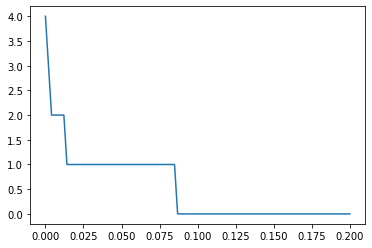

In [14]:
#パラメタｃと誤答数ｄの関係を視覚化してみる
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(c, d_list)

※このデータでは、正則化項がなくても（cをかなり大きくしても）誤答数は0であった。

## 4.6 ランダムフォレストで特徴量の重要度にアクセス

In [15]:
#ランダムフォレストの実装
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500,
                             random_state=1)

rfc.fit(X_train_std, y_train)
y_pred = rfc.predict(X_test_std)

(y_test != y_pred).sum()

0

`.feature_importances_`で各特徴量の重要度を取得することが出来る。

In [22]:
#特徴量の重要度を抽出
importances = rfc.feature_importances_
importances.reshape(1,13)

array([[0.11852942, 0.02564836, 0.01327854, 0.02236594, 0.03135708,
        0.05087243, 0.17475098, 0.01335393, 0.02556988, 0.1439199 ,
        0.058739  , 0.13616194, 0.1854526 ]])

この結果から重要そうなのは  
(1)Proline           :0.185453  
(2)Flavanoids        :0.174751  
(3)Color intensity   :0.143920  

#### （注意）相関が高い二つの特徴量があった場合、片方がランキング上位にいるともう一方は下がっていることがある。

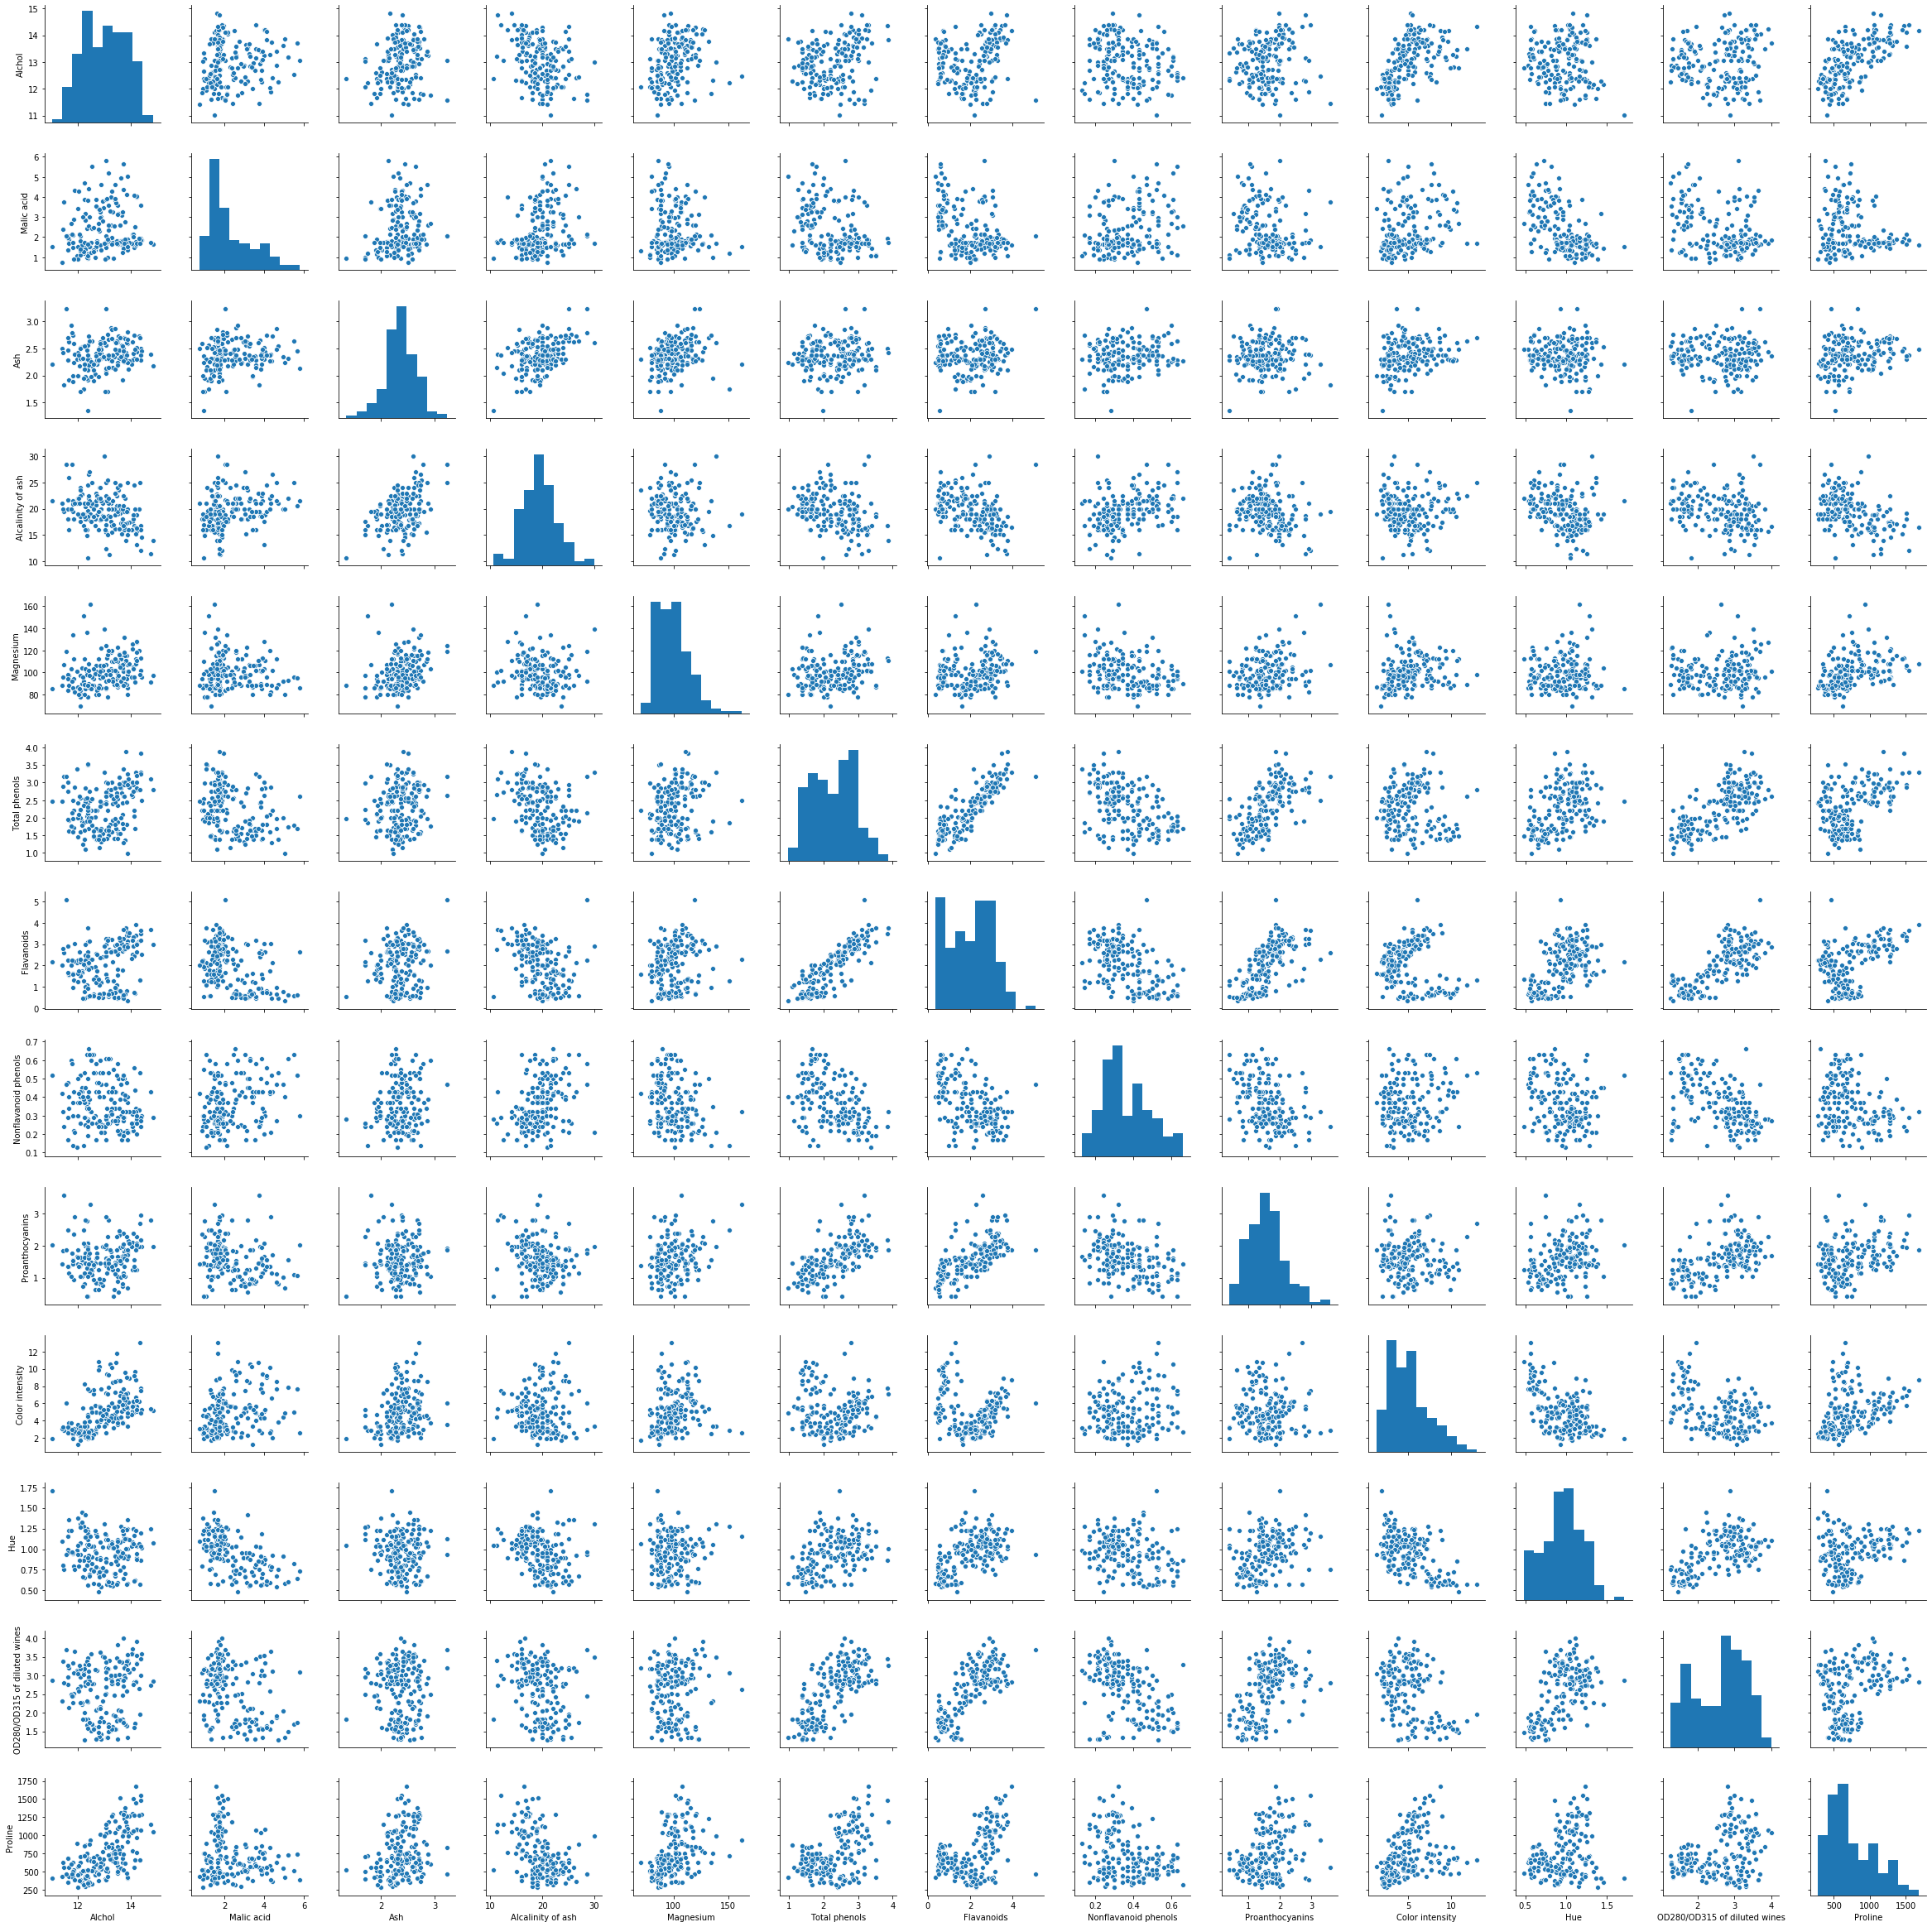

In [26]:
import seaborn as sns
sns.pairplot(df_wine.iloc[:, 1:])